In [1]:
import numpy as np
from PIL import Image
from toolbox.printing import debug
import torch
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

from losses import smooth_skeleton_dice_loss, smooth_skeleton_intersection_loss
from smooth_skeletonization import soft_skeletonize, soft_skeletonize_thin
from smooth_gaussian_diffusion import apply_smooth_gaussian_diffusion
from visualization import show_mask, show_image
from utils import separate_mask, crop_as_small_as_possible
from metrics import crack_metrics

/media/jsomerviller/SSD2/anaconda3/envs/reachbot/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data

In [2]:
crack_idx = 54
path_image = f"../datasets/cracks/cropped/val/images/{crack_idx}.png"
path_mask = f"../datasets/cracks/cropped/val/masks/{crack_idx}.png"

# Load the image and mask
# Load image and mask and converts them to numpy arrays
image = Image.open(path_image)
mask = Image.open(path_mask)
image = np.array(image)
mask = np.array(mask)

## See the data

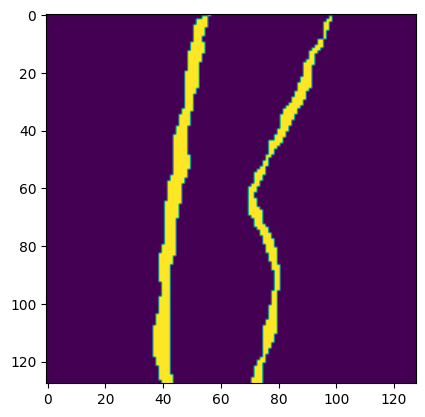

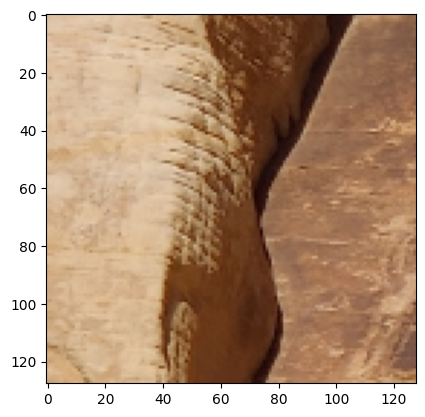

In [3]:
show_mask(mask)
show_image(image)

## Skeletonization functions comparison

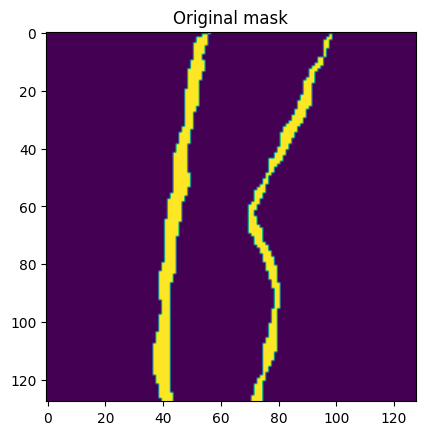

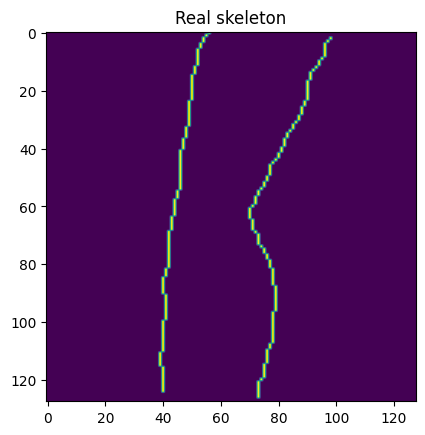

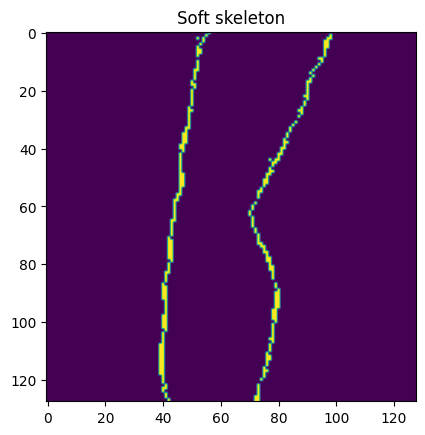

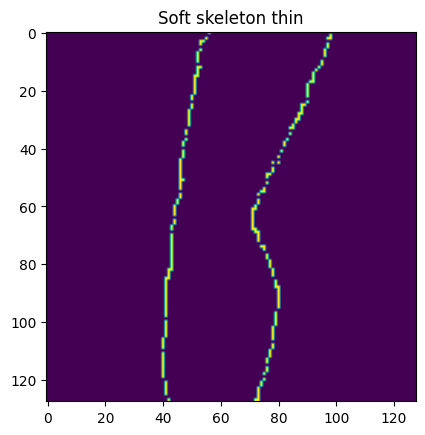

In [4]:
# Show the different version of the skeletonization
real_skeleton = skeletonize(mask, method='lee') # https://stackoverflow.com/questions/56394869/how-to-estimate-piece-wise-smooth-fit-to-a-noisy-mask
mask_tensor = torch.from_numpy(mask).float().unsqueeze(0)
soft_skeleton = soft_skeletonize(mask_tensor, 5).squeeze(0).squeeze(0) > 0.5
soft_skeleton_thin = soft_skeletonize_thin(mask_tensor, 10).squeeze(0) > 0.5

# Show original mask
show_mask(mask, "Original mask")
show_mask(real_skeleton, "Real skeleton")
show_mask(soft_skeleton, "Soft skeleton")
show_mask(soft_skeleton_thin, "Soft skeleton thin")

## Gaussian diffusion demo and compatibility with Soft skeletonize

DEBUG: soft_skeleton_thin (Tensor: float32) = [] (1, 128, 128) (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)
DEBUG: soft_skeleton_thin.max( (Tensor: float32) = 1.0 () (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)
DEBUG: soft_skeleton_thin.min( (Tensor: float32) = 0.0 () (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)


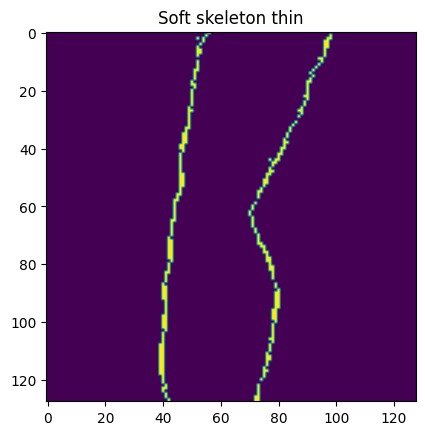

DEBUG: mask_wide (Tensor: float32) = [[[4.6...]] (1, 128, 128) (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)
DEBUG: mask_wide.max( (Tensor: float32) = 1.0 () (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)
DEBUG: mask_wide.min( (Tensor: float32) = 8.8081719...6e-08 () (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)


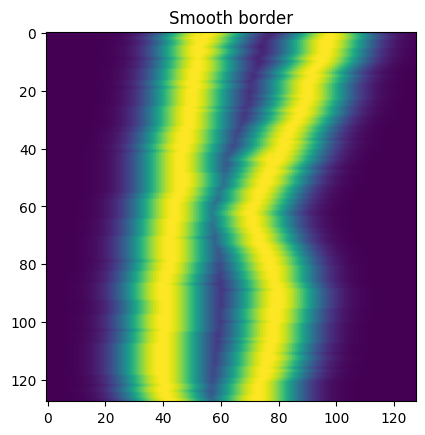

DEBUG: skeleton_wide (Tensor: float32) = [[...]] (1, 128, 128) (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)
DEBUG: skeleton_wide.max( (Tensor: float32) = 0.606...89685 () (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)
DEBUG: skeleton_wide.min( (Tensor: float32) = 0.0 () (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)


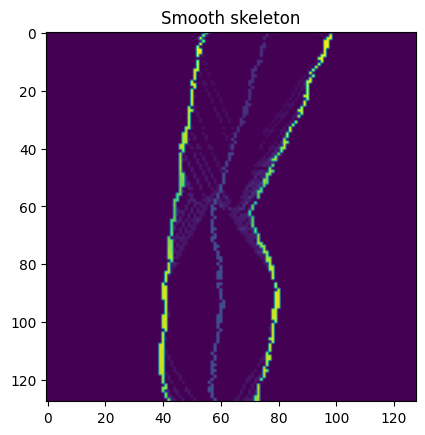

In [5]:
input_tensor = mask_tensor.float()
soft_skeleton_thin = soft_skeletonize(input_tensor, 10)
debug(soft_skeleton_thin)
debug(soft_skeleton_thin.max())
debug(soft_skeleton_thin.min())
show_mask(soft_skeleton_thin.squeeze(0), "Soft skeleton thin")
mask_wide = apply_smooth_gaussian_diffusion(soft_skeleton_thin, 128, 10.0)
debug(mask_wide)
debug(mask_wide.max())
debug(mask_wide.min())
show_mask(mask_wide.squeeze(0), "Smooth border")
skeleton_wide = soft_skeletonize(mask_wide, 128)
debug(skeleton_wide)
debug(skeleton_wide.max())
debug(skeleton_wide.min())
show_mask(skeleton_wide.squeeze(0), "Smooth skeleton")

## Generate a fake prediction slightly off-center and rotated

### First separate the image for each crack

Found 2 connected components


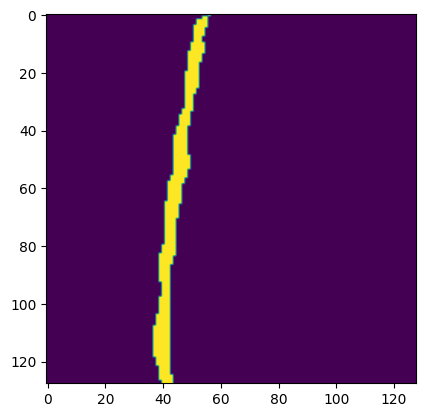

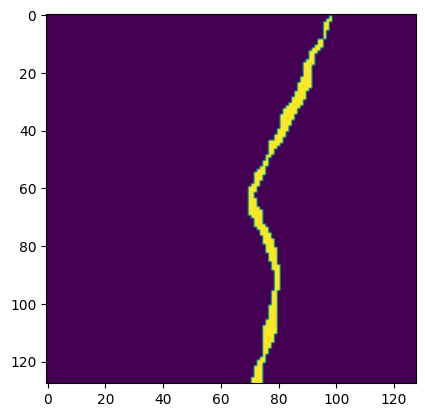

In [6]:
# Label the connected components
masks = separate_mask(mask)
print(f"Found {len(masks)} connected components")
for separated_mask in masks:
    show_mask(separated_mask)

### Generate a prediction

In [7]:
import scipy

def generate_prediction(mask, movement=1, scale=1, noise=1):
    prediction = mask.copy()
    # Introduce random translation, rotation and even scaling (small amount)
    prediction = scipy.ndimage.rotate(prediction, np.random.uniform(-10*movement, 10*movement), reshape=False)
    prediction = scipy.ndimage.shift(prediction, np.random.uniform(-10*movement, 10*movement, size=2))
    # Zoom but keep the same size
    prediction = scipy.ndimage.zoom(prediction, np.random.uniform(1-0.1*scale, 1+0.1*scale))
    # If the image is too big, crop it
    if prediction.shape[0] > mask.shape[0] or prediction.shape[1] > mask.shape[1]:
        prediction = prediction[:mask.shape[0], :mask.shape[1]]
    # If the image is too small, pad it
    if prediction.shape[0] < mask.shape[0] or prediction.shape[1] < mask.shape[1]:
        prediction = np.pad(prediction, ((0, mask.shape[0]-prediction.shape[0]), (0, mask.shape[1]-prediction.shape[1])), mode='constant')
    # Add noise
    prediction = prediction + np.abs(np.random.normal(0, 0.7 * noise, prediction.shape)) / (1+scipy.ndimage.distance_transform_edt(prediction <= 0.5))**2
    prediction = prediction >= 0.5
    return prediction

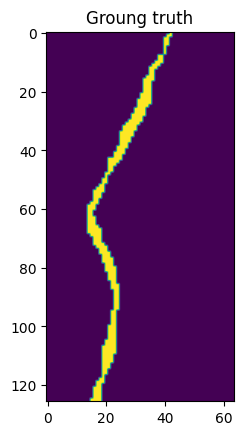

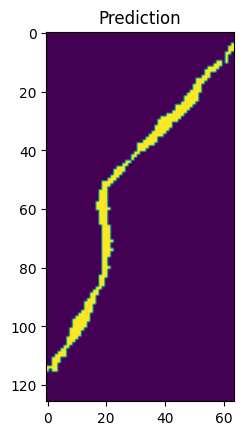

In [8]:
gt = masks[1]
pred = generate_prediction(gt, movement=3.0, scale=0, noise = 0)
gt_cropped, pred_cropped = crop_as_small_as_possible(gt, pred)
show_mask(gt_cropped, "Groung truth")
show_mask(pred_cropped, "Prediction")

### Evaluate the metrics on the prediction

In [9]:
crack_metrics(gt, pred)

{'length': 0.9077609612738833,
 'line_distance': 0.581663636294291,
 'width': 0.9341667173741621,
 'iou': 0.03783783783783784,
 'dice': 0.07291666666666667}

### Compute the loss

In [10]:
pred_tensor = torch.from_numpy(pred).unsqueeze(0).float()
pred_tensor.requires_grad = True
debug(pred_tensor)
gt_tensor = torch.from_numpy(gt).unsqueeze(0).float()
gt_tensor.requires_grad = True
debug(gt_tensor)
print("smooth_skeleton_intersection_loss:",
    smooth_skeleton_intersection_loss(gt_tensor, pred_tensor, iterations=10, border_size=25, sigma=10.0, thinner=False, epsilon=1e-6)
)
print("smooth_skeleton_dice_loss:",
    smooth_skeleton_dice_loss(gt_tensor, pred_tensor, iterations=10, border_size=25, sigma=10.0, thinner=False)
)

DEBUG: pred_tensor (Tensor: float32) = [[[....]] (1, 128, 128) (cpu) (req-grad)
DEBUG: gt_tensor (Tensor: float32) = [[[......]] (1, 128, 128) (cpu) (req-grad)
smooth_skeleton_intersection_loss: tensor([0.3862], grad_fn=<RsubBackward1>)
smooth_skeleton_dice_loss: tensor([0.2705], grad_fn=<RsubBackward1>)
